initializing parameters. I'll explain why i chosed these values

In [1]:
import time
s = time.perf_counter()
import random

firstPopulationNum = 6000 
populationNum = 2000 
PMutation = 0.035
PRep = 0.06
iterations = 100
t = 3

read file

In [2]:

bayg29 = open('bayg29.tsp', 'r')
for i in range (3):
    bayg29.readline()

numOfCities = int(bayg29.readline().strip().split()[1])

for i in range (4):
    bayg29.readline()

weightedVertices = []
for i in range(numOfCities -1):
     weightedVertices.append(list(map(int,(bayg29.readline().strip().split()[0:]))))

bayg29.close()

class for Chromosome(Routes)

In [3]:
class Route():
    def __init__(self):
        self.holeDistance = 0 # fitness - The shorter the distance the more fitness!
        self.path = []

    def distance(self,cityIndex):
        if self.path[cityIndex]<self.path[cityIndex+1]:
           return weightedVertices [self.path[cityIndex]]  [self.path[cityIndex+1] - self.path[cityIndex] -1 ]
        else:
           return weightedVertices[self.path[cityIndex+1]] [self.path[cityIndex] - self.path[cityIndex+1] -1 ]

    def hole_distance(self):
        self.holeDistance = 0
        for i in range(len(self.path)-1):
            self.holeDistance+= self.distance(i)

class FirstRoute(Route) :
    def __init__(self) :
        Route.__init__(self)
        self.path = random.sample(list(range(numOfCities)), numOfCities)

In [4]:
def best(l):
    ans = l[0]
    for r in l:
        if r.holeDistance<ans.holeDistance:
            ans = r
    return ans

def average(l):
    sum = 0
    for r in l:
        sum+=r.holeDistance
    return sum/(len(l))

def worst(l):
    ans = l[0]
    for r in l:
        if r.holeDistance>ans.holeDistance:
            ans = r
    return ans

def index_of_worst(l):
    ans = 0
    for i in range(len(l)):
        if l[i].holeDistance>l[ans].holeDistance:
            ans = i
    return ans


In [5]:
def tournament_selection(Population, m, k): #m times choose k element and return the best of k choosen element(m elements)
    def tournament(Population, k):
        index = random.sample(list(range(len(Population))), k)
        l = []
        for i in index:
            l.append(Population[i])
        return best(l)

    newPopulation = []
    for ـ in range(m):
        newPopulation.append(tournament(Population, k))

    return newPopulation

I used Cycle_Recombination and Order_recombination to recombine. But in several experiments, the former performed better than the latter. I did not use the latter

In [6]:
def Cycle_Recombination(parents):
    def get_groups(parent1,parent2):
        def sorted_union(nestedList):
            newList = []
            for list in nestedList:
                newList += list
            newList.sort()
            return newList

        def smallest_index_which_is_not_in_list(list):
            if list :
                for i in range (len(list)+1):
                    if i not in list:
                        return i
            else:
                return 0

        def recombination(groups):
            l = [-1 for _ in range(numOfCities)]
            mainParent = parent1
            for group in groups:
                for i in group:
                    l[i] = mainParent[i]
                mainParent = parent1 if mainParent == parent2 else parent2
            ans = Route()
            ans.path = l
            return ans

        lO = []
        while len(sorted_union(lO)) != len(parent1) :
            startPoint = smallest_index_which_is_not_in_list(sorted_union(lO))
            lI = []
            while True:
                lI.append(startPoint)
                city2 = parent2[startPoint]
                for i,city1 in enumerate(parent1):
                    if city1 == city2:
                        startPoint = i
                        break
                    
                if startPoint in lI :
                    lO.append(lI)
                    break        

        return recombination(lO)

    
    children = []
    for _ in range(len(parents)):
        i=random.randint(0,numOfCities)
        children.append(get_groups(parents[i].path, parents[i+1].path))
    return children

In [7]:
def Order_recombination(parents):
    def recombination(parent1, parent2):
        def get_start_end():
            a = random.sample(list(range(numOfCities)),2 )
            a.sort()
            return a
        
        l = [-1 for _ in range(numOfCities)]
        startPoint, endPoint = get_start_end()
        for i in range(startPoint, endPoint+1):
                l[i]=parent1[i]

        j = endPoint+1 if endPoint != numOfCities-1 else 0 

        for i in range(endPoint+1, numOfCities):
            while parent2[j] in l:
                j+=1
                if j==numOfCities:
                    j = 0
            l[i]=parent2[j]
            j+=1
            if j==numOfCities:
                    j = 0

        for i in range(startPoint):
            while parent2[j] in l:
                j+=1
                if j==numOfCities:
                    j = 0
            l[i]=parent2[j]
            j+=1
            if j==numOfCities:
                    j = 0
        return l
    
    children = Route()
    for i in range(0,len(parents),2):
        children.path.append(recombination(parents[i].path, parents[i+1].path))
    return children

In [8]:
def swap_mutation(population, PMutation):
    def mutation(city):
        i = random.randint(0,numOfCities-1)
        j = random.randint(0,numOfCities-1)
        temp = city.path[i]
        city.path[i] = city.path[j]
        city.path[j] = temp
        return city

    for _ in range(int(len(population)*PMutation)):
        i = random.randint(0,len(population)-1)
        population[i] = mutation(population[i])
    return population


Generational replacement algorithms usually work better for solving genetic problems

In [9]:
def generational_replacement(parents,chidren, PRep):
    for _ in range (int(populationNum*PRep)):
        indexOfWorst = index_of_worst(parents)
        parents[indexOfWorst] = best(chidren)
        chidren.remove(best(chidren))
    return parents

In [10]:
def stop(iterator, best) :
    if iterator == iterations or best.holeDistance <= 1600 :
        return True
    return False

In [11]:
firstPopulation = [FirstRoute() for _ in range(firstPopulationNum)]  #step1: create first population

for i in firstPopulation:                                     #step2: calculate first population fitness
    i.hole_distance()

In [12]:
iterator = 0
parents = firstPopulation
bestIter = []
aveIter = []
worsIter = []
while not stop(iterator, best(parents)) :                     #step8: stop check 
    
    bestIter.append(best(parents).holeDistance)
    aveIter.append(average(parents))
    worsIter.append(worst(parents).holeDistance)
          
    parents = tournament_selection(parents, populationNum, t) #step3: select

    children = Cycle_Recombination(parents)                   #step4: recombination
    # print(len(children))
    children = swap_mutation(children,PMutation)              #step5: mutation
    
    for city in children:                                     #step6: calculate fitness
        city.hole_distance()

    parents = generational_replacement(parents, children, PRep)#step7: replacement 
    iterator+=1
print("answer is:",best(parents).holeDistance, best(parents).path)


answer is: 1751 [10, 21, 16, 13, 17, 14, 24, 6, 22, 12, 9, 19, 28, 2, 25, 4, 8, 11, 5, 27, 0, 20, 1, 3, 18, 15, 23, 26, 7]


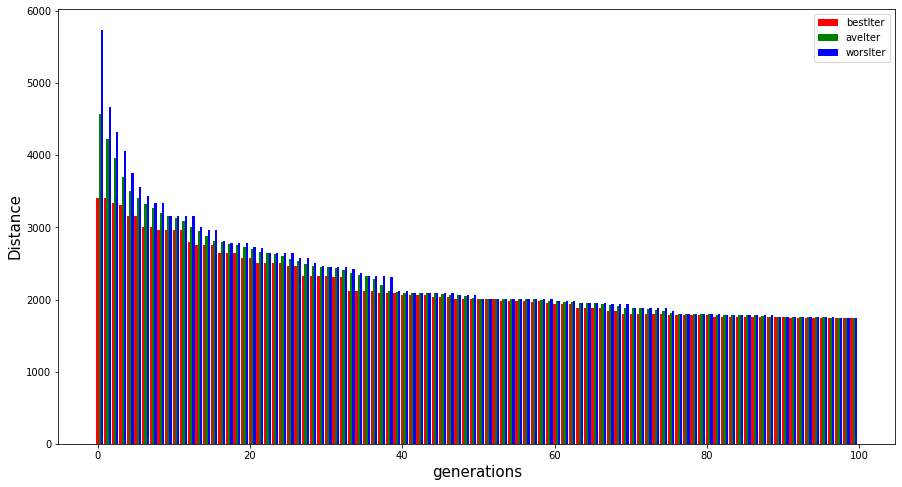

it takes 34.448722040000575 seconds


In [13]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.3
fig = plt.subplots(figsize =(15, 8))
 
br1 = np.arange(len(bestIter))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, bestIter, color ='r', width = barWidth, label ='bestIter')
plt.bar(br2, aveIter, color ='g', width = barWidth, label ='aveIter')
plt.bar(br3, worsIter, color ='b', width = barWidth, label ='worsIter')
 
# Adding Xticks
plt.xlabel('generations', fontsize = 15)
plt.ylabel('Distance', fontsize = 15)

plt.legend()
plt.show()
print("it takes",time.perf_counter()-s,"seconds")

Select parameters:

I considered the initial population large to have a lot of variety. But I reduced the main population to the point where it does not converge quickly and is diverse so that the algorithm does not slow down.

The mutation well prevented rapid convergence. But when I made the mutation higher than it is now, there was a divergence. 100 repetitions are enough, and out of the 20 times I ran the code, usually between the 80th and 100th repetitions, the answers converged to about 1800.

Of course, these parameters are not independent.
 For example, when I subtracted the initial population and the main population (about 200), I reached the answer with a very high number of repetitions